In [4]:
!pip install minio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 2.3 MB/s eta 0:00:00a 0:00:01
  Using cached pycryptodome-3.21.0-cp36-abi3-macosx_10_9_universal2.whl (2.5 MB)
  Using cached argon2_cffi_bindings-21.2.0-cp38-abi3-macosx_10_9_universal2.whl (53 kB)


In [5]:
from minio import Minio
import pandas as pd
import numpy as np
from io import BytesIO

client = Minio("localhost:9000",
    access_key="5MpW7tf4J1U4KKvzLm7X",
    secret_key="bOpLlAAeSqJgfZBvLZFNRZA9o1eP5Mc7l7ea8R4V",
    secure=False,
)


def fetch_from_minio(filename, bucket_name):

    response = client.get_object(bucket_name, filename)
    
    try:
        file_content = BytesIO(response.read())
        df = pd.read_csv(file_content, index_col=False)
    finally:
        response.close()
        response.release_conn()
    return df

df_final = fetch_from_minio("merged_preprocessed.csv", "datasets")

In [6]:
df_final['time'] = pd.to_datetime(df_final['time'], utc=True, infer_datetime_format=True)
df_final = df_final.set_index('time')

/var/folders/v7/bdkd1w4x4lb24ppj_z8h56fh0000gn/T/ipykernel_6987/537998211.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_final['time'] = pd.to_datetime(df_final['time'], utc=True, infer_datetime_format=True)


In [7]:
pd.set_option('display.max_columns', None)  # Show all columns

In [8]:
df_final.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,weather_id_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,weather_id_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_id_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,snow_3h_Seville,clouds_all_Seville,weather_id_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,800.0,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,800.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,800.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,800.0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,800.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,800.0,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,800.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,800.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,800.0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,800.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,800.0,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,800.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,800.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,800.0,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,800.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,800.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,800.0,269.485500,269.485500,269.485500,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,800.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,800.0


In [9]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

In [10]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

In [11]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In [ ]:
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

In [ ]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [ ]:
cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [ ]:
# Generate 'temp_weighted' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

In [ ]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [ ]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [ ]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [ ]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

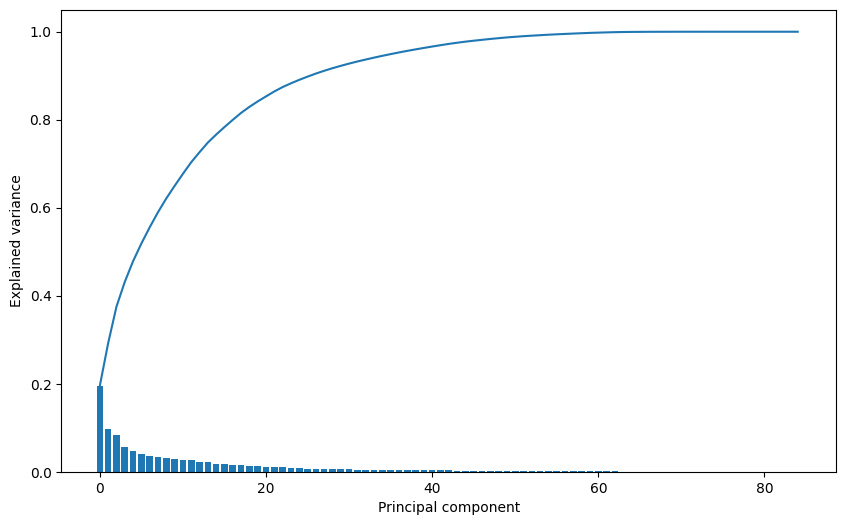

In [ ]:
import matplotlib.pyplot as plt

num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [ ]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [ ]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [ ]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [ ]:
def save_df_as_csv_to_minio(df, fileName, idx=False):
    csv_bytes = df.to_csv(index=idx).encode('utf-8')
    csv_buffer = BytesIO(csv_bytes)

    client.put_object(
        'datasets', fileName, data=csv_buffer, length=len(csv_bytes), content_type="application/csv"
    )


In [ ]:
X_train.shape

(27024, 24, 19)

In [ ]:
y_train.shape

(27024,)

In [ ]:
import torch
tensor_test = torch.from_numpy(X_train).float()


NameError: name 'X_train' is not defined

In [ ]:
import numpy as np
import torch

def save_feature(arr: np.ndarray, metadata_version, metadata_date, filename, bucket):

    tensor = torch.from_numpy(arr).float()

    filename = f"{filename}_v{metadata_version}_{metadata_date}_"

    buffer = BytesIO()
    torch.save(tensor, buffer)

    client.put_object(
    'datasets', filename, data=buffer, length=len(buffer), content_type="application/octet-stream"
)

# Save to a file
torch.save(data_to_save, "features_with_metadata.pt")

# Load the file
loaded_data = torch.load("features_with_metadata.pt")

# Access the tensor and metadata
loaded_features = loaded_data["features"]
loaded_metadata = loaded_data["metadata"]

print("Loaded Tensor Shape:", loaded_features.shape)
print("Metadata:", loaded_metadata)
